In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import contextily
import folium
import math
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import plotly.express as px


In [7]:
df=pd.read_csv('C:/Users/ramon/Downloads/Motor_Vehicle_Collisions_-_Crashes (1).csv') 
df.columns

C:\Users\ramon\AppData\Local\Temp\ipykernel_32832\669977887.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('C:/Users/ramon/Downloads/Motor_Vehicle_Collisions_-_Crashes (1).csv')


Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

C:\Users\ramon\AppData\Local\Temp\ipykernel_32832\2123098334.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='HOUR', palette='viridis')


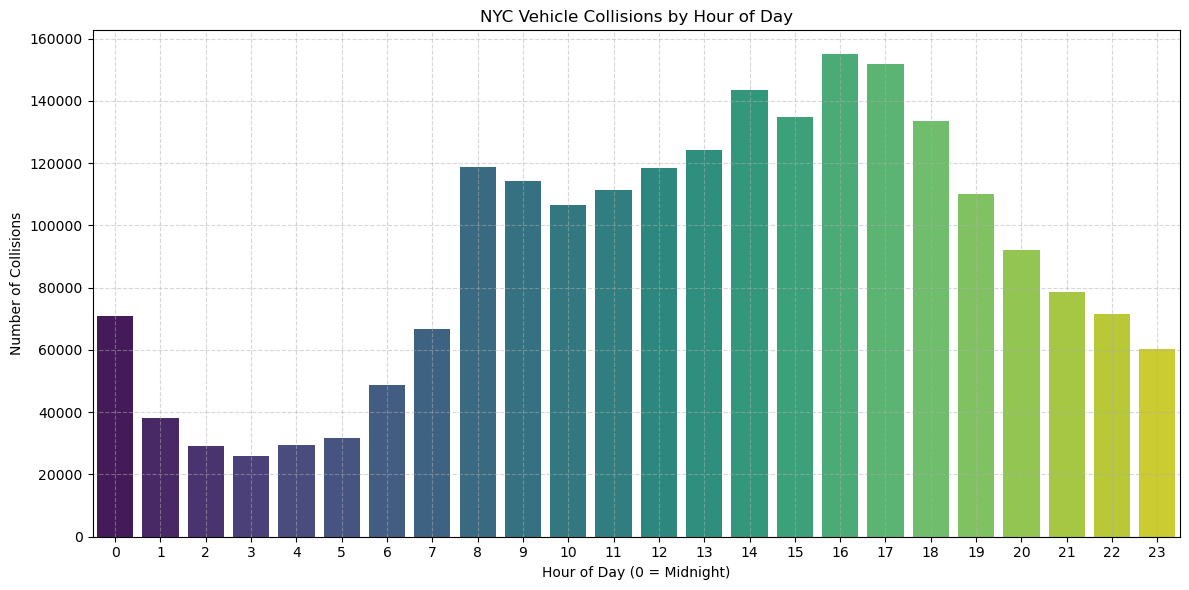

In [8]:
# Convert 'CRASH TIME' to datetime
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M', errors='coerce')

# Drop rows where conversion failed
df = df.dropna(subset=['CRASH TIME'])

# Extract hour of day
df['HOUR'] = df['CRASH TIME'].dt.hour

plt.figure(figsize=(12,6))
sns.countplot(data=df, x='HOUR', palette='viridis')
plt.title('NYC Vehicle Collisions by Hour of Day')
plt.xlabel('Hour of Day (0 = Midnight)')
plt.ylabel('Number of Collisions')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

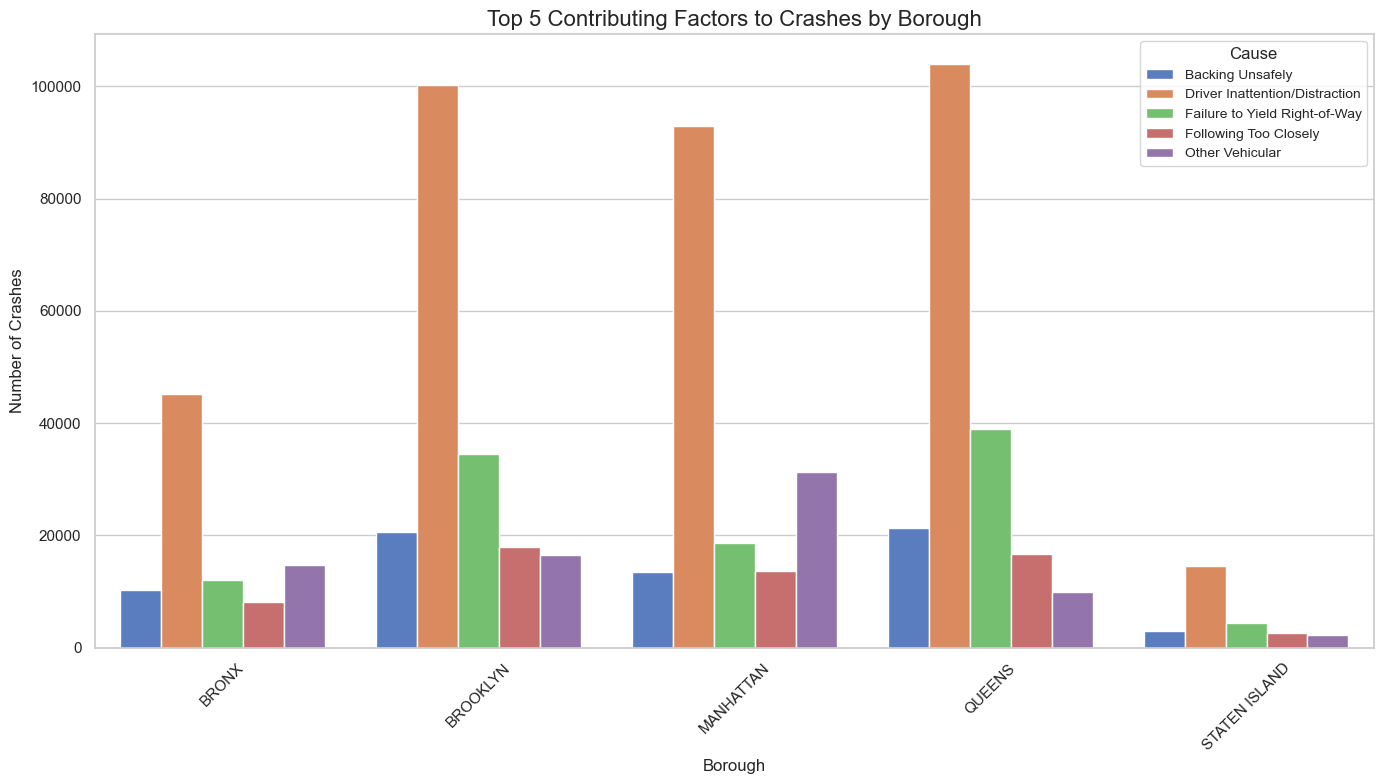

In [9]:
#Crash Reason by Borough
relevant_columns = [col for col in df.columns if 'CONTRIBUTING FACTOR' in col or 'BOROUGH' in col]
df[relevant_columns].head()


crash_causes_df = df[['BOROUGH', 
                      'CONTRIBUTING FACTOR VEHICLE 1', 
                      'CONTRIBUTING FACTOR VEHICLE 2',
                      'CONTRIBUTING FACTOR VEHICLE 3',
                      'CONTRIBUTING FACTOR VEHICLE 4',
                      'CONTRIBUTING FACTOR VEHICLE 5']].copy()


crash_causes_df.dropna(subset=['BOROUGH'], inplace=True)


melted = crash_causes_df.melt(id_vars='BOROUGH', 
                              value_vars=[
                                  'CONTRIBUTING FACTOR VEHICLE 1', 
                                  'CONTRIBUTING FACTOR VEHICLE 2',
                                  'CONTRIBUTING FACTOR VEHICLE 3',
                                  'CONTRIBUTING FACTOR VEHICLE 4',
                                  'CONTRIBUTING FACTOR VEHICLE 5'],
                              var_name='VEHICLE', value_name='CAUSE')


melted = melted.dropna(subset=['CAUSE'])
melted = melted[melted['CAUSE'].str.upper() != 'UNSPECIFIED']


cause_by_borough = melted.groupby(['BOROUGH', 'CAUSE']).size().reset_index(name='COUNT')



sns.set(style="whitegrid")


top_causes = (
    cause_by_borough.groupby("CAUSE")["COUNT"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)


filtered_data = cause_by_borough[cause_by_borough["CAUSE"].isin(top_causes)]


plt.figure(figsize=(14, 8))
sns.barplot(
    data=filtered_data,
    x="BOROUGH",
    y="COUNT",
    hue="CAUSE",
    palette="muted"
)

plt.title("Top 5 Contributing Factors to Crashes by Borough", fontsize=16)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Number of Crashes", fontsize=12)
plt.legend(title="Cause", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
#Want to include Contributing Factors by the vehicles, and number of people injured
print(df.shape)

(2165608, 30)


In [11]:
#Creating subset

cols = ['NUMBER OF PERSONS INJURED', 'CONTRIBUTING FACTOR VEHICLE 1',
        'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3']
motor_factors = df[cols].copy()

motor_factors.head()

,NUMBER OF PERSONS INJURED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3
0,2.0,Aggressive Driving/Road Rage,Unspecified,NaN
1,1.0,Pavement Slippery,NaN,NaN
2,1.0,Unspecified,Unspecified,Unspecified
3,0.0,Following Too Closely,Unspecified,NaN
4,0.0,Passing Too Closely,Unspecified,NaN


C:\Users\ramon\AppData\Local\Temp\ipykernel_32832\3603776805.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


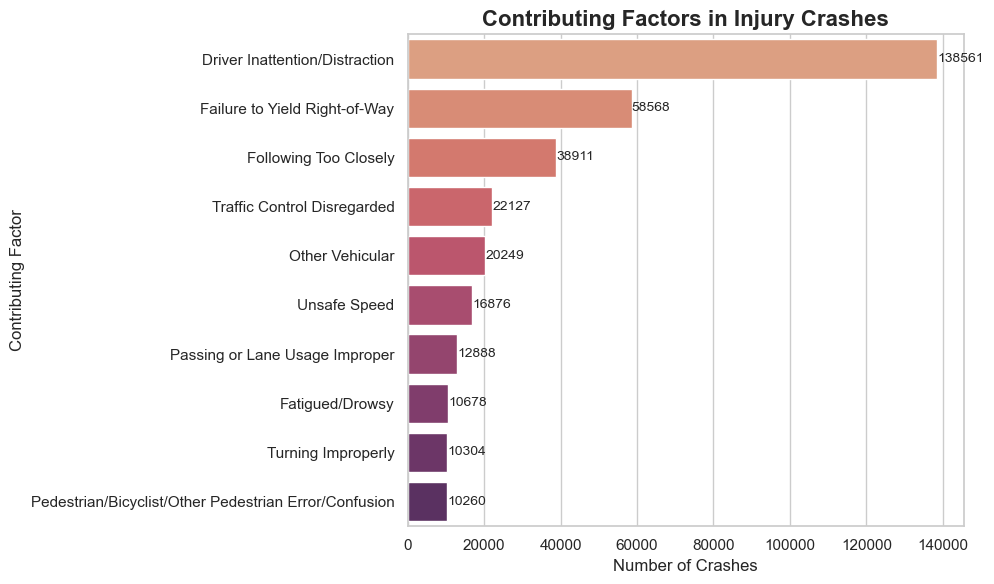

In [12]:
motor_injured = motor_factors[motor_factors['NUMBER OF PERSONS INJURED'] > 0]

factors = pd.concat([
    motor_injured['CONTRIBUTING FACTOR VEHICLE 1'],
    motor_injured['CONTRIBUTING FACTOR VEHICLE 2'],
    motor_injured['CONTRIBUTING FACTOR VEHICLE 3']
], ignore_index=True)

factors = factors.dropna()
factors = factors[factors != 'Unspecified']

sns.set(style="whitegrid")

# Count occurrences of each factor and sort them in descending order
top_factors = factors.value_counts().head(10)  

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_factors.values,
    y=top_factors.index,
    palette="flare"
)

plt.title("Contributing Factors in Injury Crashes", fontsize=16, weight='bold')
plt.xlabel("Number of Crashes", fontsize=12)
plt.ylabel("Contributing Factor", fontsize=12)

# Add value labels to bars
for index, value in enumerate(top_factors.values):
    plt.text(value + 100, index, str(value), va='center', fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\ramon\AppData\Local\Temp\ipykernel_32832\2961766215.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



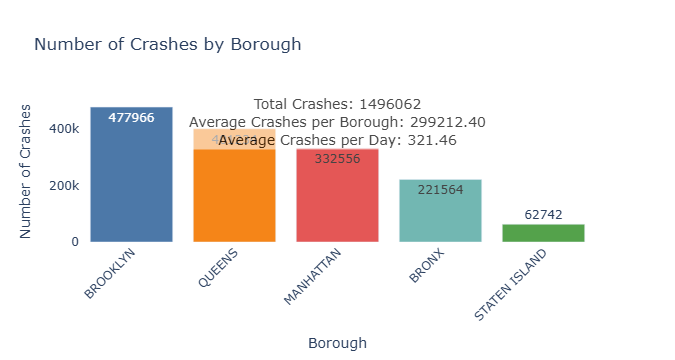

In [21]:
df_clean = df.dropna(subset=['BOROUGH'])

df_clean['CRASH DATE'] = pd.to_datetime(df_clean['CRASH DATE'], errors='coerce')

borough_counts = df_clean['BOROUGH'].value_counts().reset_index()
borough_counts.columns = ['Borough', 'Number of Crashes']

total_crashes = borough_counts['Number of Crashes'].sum()
average_crashes = borough_counts['Number of Crashes'].mean()

unique_dates = df_clean['CRASH DATE'].nunique()
average_crashes_per_day = total_crashes / unique_dates

fig = px.bar(borough_counts,
             x='Borough',
             y='Number of Crashes',
             title=f'Number of Crashes by Borough ',
             labels={'Borough': 'Borough', 'Number of Crashes': 'Number of Crashes'},
             color='Borough', 
             color_discrete_sequence=px.colors.qualitative.T10,  
             text='Number of Crashes')  


fig.update_layout(
    xaxis_title='Borough',
    yaxis_title='Number of Crashes',
    xaxis_tickangle=-45,  
    plot_bgcolor='rgba(0,0,0,0)',  
    paper_bgcolor='rgba(255,255,255,0.8)',  
    showlegend=False  
)


fig.update_traces(
    hovertemplate='<b>%{x}</b><br>Crashes: %{y}<br><extra></extra>'  
)


fig.add_annotation(
    x=0.5, y=1.05, xref='paper', yref='paper',
    text=f'Total Crashes: {total_crashes}<br>Average Crashes per Borough: {average_crashes:.2f}<br>Average Crashes per Day: {average_crashes_per_day:.2f}',
    showarrow=False, font=dict(size=14, color='black'),
    align='center', bgcolor='rgba(255,255,255,0.8)', opacity=0.7
)

fig.show()

In [ ]:
#This interactive bar chart above displays the number of vehicle crashes by borough in New York City. Brooklyn has the highest number of
#crashes, totaling 478,871, followed by Queens with 401,897. Manhattan and the Bronx reported 333,034 and 221,959 crashes and
# Staten Island had the fewest at 62,843. In total, there were 1,498,604 crashes across all five boroughs. On average, this equates
#to about 299,720 crashes per borough and approximately 321 crashes per day.

In [46]:
# Readying data, replacing blank values with np.nan
data_file = gpd.read_file('C:/Users/ramon/Downloads/Motor_Vehicle_Collisions_-_Crashes (1).csv')

data_file['LATITUDE'] = data_file['LATITUDE'].replace('', np.nan)
data_file['LONGITUDE'] = data_file['LONGITUDE'].replace('', np.nan)

# Clearing out non-available values for lat and long
data_file = data_file.dropna(subset=['LATITUDE'])
data_file = data_file.dropna(subset=['LONGITUDE'])

# Limit to first 500 entries
data_file = data_file.head(500)

# Create a map with Folium
# Here, the location points to the center of Austin, and we've zoomed out
# enough to get a good view
m_2 = folium.Map(location=[40.7128, -74.0060], tiles='cartodbpositron', zoom_start=13)

# Add points to the map
for idx, row in data_file.iterrows():
    Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(m_2)

# Display the map
m_2

In [45]:
# Create a base map
m_5 = folium.Map(location=[40.7128, -74.0060], tiles='cartodbpositron', zoom_start=12)

# Add a heatmap to the base map
HeatMap(data=data_file[['LATITUDE', 'LONGITUDE']], radius=10).add_to(m_5)

# Display the map
m_5

In [ ]:
#This geospatial map above visualizes motor vehicle collision locations across New York City using a subset of 500 entries from the dataset. 
#It includes a point marker map showing individual crashes and a heatmap to highlight areas with higher concentrations of incidents. 
#The visualization provides clear spatial patterns to identify hotspots and better understand collision distribution in NYC.